# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.tail()

,doc_body,doc_description,doc_full_name,doc_status,article_id
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
#df_merged = pd.merge(df, df_content, on="article_id")
articles = df_content["doc_full_name"].unique()
users = df["email"].unique()

print(f"Dataset comes with {articles.shape[0]} articles and {users.shape[0]} different users")

Dataset comes with 1051 articles and 5149 different users


Let's get a first overview about the user interactions

In [5]:
articles_per_user = df.get(["email", "article_id"]).groupby("email").count()["article_id"]
articles_per_user.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

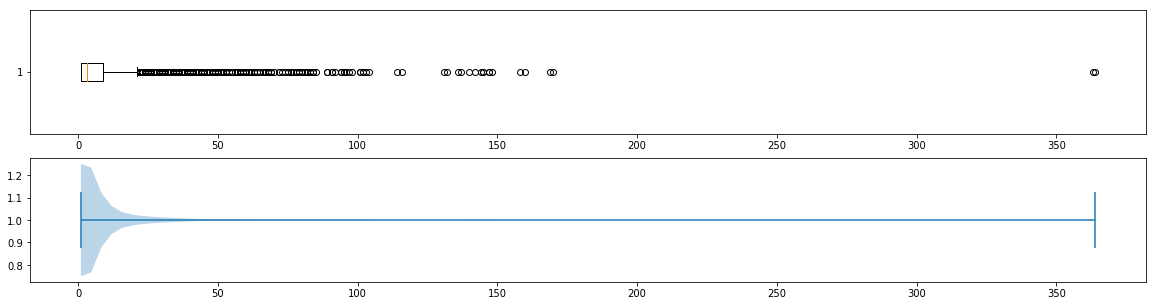

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(20,5))
ax[0].boxplot(articles_per_user, vert = False)
ax[1].violinplot(articles_per_user, vert = False)
plt.show()

In [7]:
# Fill in the median and maximum number of user_article interactios below

median_val = articles_per_user.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = articles_per_user.max()# The maximum number of user-article interactions by any 1 user is ______.

print(f"50% of individuals interact with {median_val} number of articles or fewer. The maximum number of user-article interactions by any 1 user is {max_views_by_user}.")

50% of individuals interact with 3.0 number of articles or fewer. The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles
df_content[df_content["article_id"].duplicated(keep=False)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [9]:
# Remove any rows that have the same article_id - only keep the first
article_count_original = df_content.shape[0]
df_unique_article_id = df_content[df_content["article_id"].duplicated(keep="first")]
article_count_actual = article_count_original - df_unique_article_id.shape[0]
print(f"Dataset comes with {article_count_original} articles, that is {article_count_actual} articles without duplicates.")
df_unique_article_id

Dataset comes with 1056 articles, that is 1051 articles without duplicates.


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
unique_articles = int(df["article_id"].drop_duplicates().shape[0])# The number of unique articles that have at least one interaction
total_articles = int(article_count_actual)# The number of unique articles on the IBM platform
unique_users = int(df.drop_duplicates("email").shape[0] -1) # The number of unique users
user_article_interactions = int(df.shape[0])# The number of user-article interactions
print(f"unique articles: {unique_articles} total articles: {total_articles} unique_users: {unique_users} user article interatctions: {user_article_interactions}")

unique articles: 714 total articles: 1051 unique_users: 5148 user article interatctions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
most_viewed_article_id = df['article_id'].value_counts(sort=True).index[0]
most_viewed_article_name = df.loc[df["article_id"] == most_viewed_article_id]["title"].iloc[0]

In [12]:
most_viewed_article_id = str(most_viewed_article_id) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts(sort=True).values[0]# The most viewed article in the dataset was viewed how many times?
print(f"Most viewed article is {most_viewed_article_id} with {max_views} views.")

Most viewed article is 1429.0 with 937 views.


In [13]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [15]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    return df["article_id"].value_counts().index[:n]

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.loc[df["article_id"].isin(get_top_article_ids(n, df))]["title"].unique()
    return top_articles # Return the top article titles from df (not df_content)

In [16]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'apache spark lab, part 1: basic concepts'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings' 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'finding optimal locations of new store using decision optimization']
Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64')


In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [18]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(dataframe):
    '''
    INPUT:
    dataframe - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
        
    unique_articles = dataframe["article_id"].unique().tolist()
    unique_users = dataframe["user_id"].unique().tolist()
    user_item_matrix = np.zeros((len(unique_users), len(unique_articles)))
    for user in unique_users:
        user_articles = dataframe.loc[dataframe["user_id"] == user]["article_id"].unique().tolist()
        for article in user_articles:
            #user_item_matrix[user-1, unique_articles.index(int(article)] = 1
            user_item_matrix[unique_users.index(user), unique_articles.index(article)] = 1
    
    df_user_item = pd.DataFrame(user_item_matrix, columns=unique_articles,index=unique_users) 
    df_user_item.index.name = "user_id"
    df_user_item.columns.name = "article_id"
    return df_user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item

article_id,1430.0,1314.0,1429.0,1338.0,1276.0,1432.0,593.0,1185.0,993.0,14.0,...,1135.0,881.0,183.0,655.0,1233.0,1156.0,555.0,708.0,575.0,972.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [21]:
def find_similar_users(user_id, user_item_matrix=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    # compute similarity of each user to the provided user
    similarity_user_pair = []
    user_articles = user_item_matrix.loc[user_id]
    
    similarity_user_pair = [(idx, np.dot(user_articles, comparison_user_articles)) for idx, comparison_user_articles in user_item_matrix.iterrows() if idx != user_id]
    
    #similarity_user_pair = [(uid, np.dot(user_item_matrix.loc(idx), user_item_matrix.loc(user_id))) ]
    # sort by similarity
    similarity_user_pair.sort(key=lambda user_score: user_score[1], reverse=True)
    # create list of just the ids
    
    # remove the own user's id
        
    return similarity_user_pair # return a list of the users in order from most to least similar

In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [(3933, 35.0), (23, 17.0), (3782, 17.0), (203, 15.0), (4459, 15.0), (131, 14.0), (3870, 14.0), (46, 13.0), (4201, 13.0), (49, 12.0)]
The 5 most similar users to user 3933 are: [(1, 35.0), (23, 17.0), (3782, 17.0), (203, 15.0), (4459, 15.0)]
The 3 most similar users to user 46 are: [(4201, 40.0), (23, 26.0), (3782, 26.0)]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [23]:
import random

def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    return df.loc[df["article_id"].isin(article_ids)]["title"].unique().tolist() # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_mapping = df["article_id"].unique().tolist()
    
    # Your code here
    article_ids = [article_mapping[article] for article in np.nonzero(user_item.loc[user_id])[0]]
    article_names = df.loc[df["article_id"].isin(article_ids)]["title"].unique().tolist()
    article_ids = [str(article) for article in article_ids]
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    def add_recommendation(article, recs):
        """ Common adding function
        INPUT
        article - (number) an article id
        recs - (list) the container where the article should be added
        
        OUTPUT:
        recs - (list) a list of recommendations for the user
        """
        article_title = get_article_names([article])
        if len(article_title) > 0 and article_title[0] not in get_article_names(recs):
            recs.append(article)
        
        return recs
        
    
    def get_unseen_recommended(recs, close_articles, m):
        """ Add recommended articles the user hasn't seen
        INPUT
        recs - (list) the container where the article should be added
        close_articles - (list) list of recommended articles from similar users
        user_articles - (list) list of recommended articles
        m - (int) the number of recommendations you want for the user
        
        OUTPUT:
        recs - (list) a list of recommendations taken from similar users
        """
        for article in close_articles:
            add_recommendation(article, recs)
            if len(recs) >= m:
                break
        return recs
    
    def extend_with_arbitrary(recs, m):
        """ Fill up with arbitrary articles the user hasn't seen
        INPUT
        recs - (list) the container where the article should be added
        m - (int) the number of recommendations you want for the user
        
        OUTPUT:
        recs - (list) a list of recommendations
        """
        article_ids = df["article_id"].tolist()
        while len(recs) < m:
            random_article = random.choice(article_ids)
            add_recommendation(random_article, recs)
        return recs
    
        
    
    close_articles = df.loc[df["user_id"].isin(find_similar_users(user_id)[:m])]["article_id"].unique()
    
    recs = get_unseen_recommended([], close_articles, m)
    recs = extend_with_arbitrary(recs, m)
    
    return recs# return your recommendations for this user_id    

In [24]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['welcome to pixiedust',
 'developing for the ibm streaming analytics service',
 'model bike sharing data with spss',
 'finding optimal locations of new store using decision optimization',
 'analyze accident reports on amazon emr spark',
 'jupyter notebook tutorial',
 'the greatest public datasets for ai – startup grind',
 'data model with streaming analytics and python',
 'three reasons machine learning models go out of sync',
 'spark 2.1 and job monitoring available in dsx']

In [25]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    def add_content(neighbor_id, similarity, num_interactions, storage, replace_previous):
        ''' Appends or replaces new content to the common storage'''
        if replace_previous:
            storage["similarity"][-1] = similarity
            storage["neighbor_id"][-1] = neighbor_id
            storage["num_interactions"][-1] = num_interactions
        else:
            storage["similarity"].append(similarity)
            storage["neighbor_id"].append(neighbor_id)
            storage["num_interactions"].append(num_interactions)
        
    
    # Your code here
    chosen_content = {"neighbor_id": [], "similarity": [], "num_interactions": []}
    user_ids_relation_pair = find_similar_users(user_id, user_item)
    
    for user_idx in range(len(user_ids_relation_pair)):        
        cur_user = user_ids_relation_pair[user_idx]
        num_cur_user_interactions = df.loc[df["user_id"] == cur_user[0]].shape[0]
        if user_idx == 0: # special case handling: avoid out of bounds error
            add_content(cur_user[0], cur_user[1], num_cur_user_interactions, chosen_content, False)
            continue
        prev_user = user_ids_relation_pair[user_idx -1]
        num_prev_user_data_interactions = df.loc[df["user_id"] == prev_user[0]].shape[0]
        
        if cur_user[1] == prev_user[1]: # if previous user is identical similar to current one, check other parameter

            if num_cur_user_interactions > num_prev_user_data_interactions: # replace if num articles of previous is smaller
                shallReplace = True
            else:
                shallReplace = False
                
            add_content(cur_user[0], cur_user[1], num_cur_user_interactions, chosen_content, shallReplace)
        else: # if comparison users have an != similarity
            add_content(cur_user[0], cur_user[1], num_cur_user_interactions, chosen_content, False)

    return pd.DataFrame(chosen_content) # Return the dataframe specified in the doc_string

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs = []
    df_top_sorted = get_top_sorted_users(user_id)
    
    # Gather base recommendations from similar users
    for _, user_data in df_top_sorted.iterrows():
        recs += df.loc[df["user_id"] == user_data["neighbor_id"]]["article_id"].unique().tolist()
        if len(recs) >= m:
            break
            
    # Order by article virality
    recs_with_interactions = [(rec, df.loc[df["article_id"] == rec].shape[0]) for rec in recs]
    recs_with_interactions.sort(key=lambda rec_pair: rec_pair[1], reverse=True)
    
    # only keep Id
    recs = [rec[0] for rec in recs_with_interactions]
    
    # prune to the requested size
    while len(recs) > m:
        del recs[-1]
        
    rec_names = [df.loc[df["article_id"] == rec]["title"].unique().tolist()[0] for rec in recs]
    return recs, rec_names

In [27]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1162.0, 1304.0, 43.0, 1351.0]

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [28]:
### Tests with a dictionary of results
user1_most_sim = find_similar_users(1)[0][0]# Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9][0]# Find the 10th most similar user to user 131

In [29]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [30]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(article) for article in get_top_article_ids(10)] # Your recommendations here



In [31]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [32]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [33]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [34]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [35]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [36]:
# Perform SVD on the User-Item Matrix Here
def get_u_s_vt(user_item_matrix):
    if not user_item_matrix.isnull().values.any(): # can only run on 'complete' matrices
        u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
    else:
        raise RuntimeError("Missing values cannot run numpy's SVD")
    return u, s, vt
u, s, vt = get_u_s_vt(user_item_matrix)

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

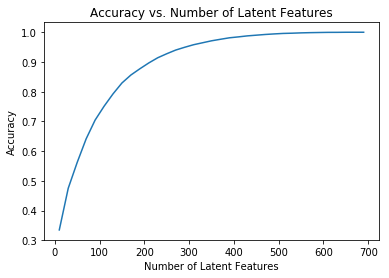

In [37]:
def get_errs(u, s, vt, lfeature_range, item_matrix):
    sum_errs = []
    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(item_matrix, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)
    return sum_errs

def draw_errs(lfeature_range, sum_errs):    
    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
    plt.xlabel('Number of Latent Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Latent Features')
    
num_latent_feats = np.arange(10,700+10,20)
sum_errs = get_errs(u, s, vt, num_latent_feats, user_item_matrix)
draw_errs(num_latent_feats, sum_errs)

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [38]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
        
    train_user_item = create_user_item_matrix(df_train)
    test_user_item = create_user_item_matrix(df_test)
    test_arts = np.intersect1d(df_train["article_id"].unique().tolist(), df_test["article_id"].unique().tolist())
    test_idx = np.intersect1d(df_train["user_id"].unique(), df_test["user_id"].unique().tolist())
    
    return train_user_item, test_user_item, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [39]:
predictable_testarts = test_arts
predictable_testusers = test_idx
non_predictable_testarts = [art for art in df_test["article_id"].unique().tolist() if art not in test_arts]
non_predictable_testusers = [user for user in df_test["user_id"].unique().tolist() if user not in test_idx]

print(f'predictable articles within test set {len(predictable_testarts)}')
print(f'non-predictable articles from test set {len(non_predictable_testarts)}')
print(f'predictable users within the test set {len(predictable_testusers)}')
print(f'non-predictable users from test set {len(non_predictable_testusers)}')

predictable articles within test set 574
non-predictable articles from test set 0
predictable users within the test set 20
non-predictable users from test set 662


In [40]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many articles can we make predictions for in the test set?': b,# letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d,# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [41]:
# fit SVD on the user_item_train matrix
streamlined_user_item_train = user_item_train.loc[user_item_train.index.intersection(predictable_testusers), user_item_train.columns.intersection(predictable_testarts)]
print(user_item_train.shape, " -> ", streamlined_user_item_train.shape)
u_train, s_train, vt_train = get_u_s_vt(streamlined_user_item_train) # fit svd similar to above then use the cells below
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 714)  ->  (20, 574)
(20, 20) (20,) (574, 574)


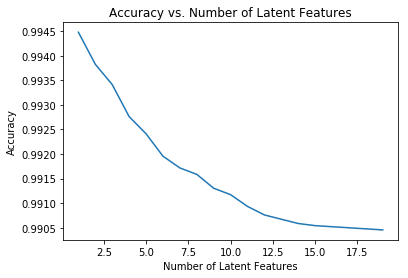

In [42]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = num_latent_feats = range(1, 20)
user_item_test_subset = user_item_test.loc[predictable_testusers]
sum_errs = get_errs(u_train, s_train, vt_train, num_latent_feats, user_item_test_subset)
draw_errs(num_latent_feats, sum_errs)

In [43]:
# check performance of top article recommendations
for user in test_idx:
    y = df.loc[df["user_id"] == user]["article_id"].unique().tolist()
    predictions = get_top_article_ids(len(y))
    matches = len([pred for pred in predictions if pred in y])
    print(f"accuracy(user_id={user}) = {matches/len(predictions)}")

accuracy(user_id=2917) = 0.0
accuracy(user_id=3024) = 0.34375
accuracy(user_id=3093) = 0.11764705882352941
accuracy(user_id=3193) = 0.16666666666666666
accuracy(user_id=3527) = 0.0
accuracy(user_id=3532) = 0.3
accuracy(user_id=3684) = 0.3783783783783784
accuracy(user_id=3740) = 0.30985915492957744
accuracy(user_id=3777) = 0.0
accuracy(user_id=3801) = 0.4
accuracy(user_id=3968) = 0.2
accuracy(user_id=3989) = 0.0
accuracy(user_id=3990) = 0.0
accuracy(user_id=3998) = 0.09090909090909091
accuracy(user_id=4002) = 0.1
accuracy(user_id=4204) = 0.23076923076923078
accuracy(user_id=4231) = 0.2727272727272727
accuracy(user_id=4274) = 0.13043478260869565
accuracy(user_id=4293) = 0.4222222222222222
accuracy(user_id=4487) = 0.1111111111111111


In [44]:
# check performance of user comparison recommendations
for user in test_idx:
    predictions = user_user_recs_part2(user)[0]
    y = df.loc[df["user_id"] == user]["article_id"].unique().tolist()
    matches = len([pred for pred in y if pred in predictions]) # turn around logic as users may have interacted with a different amount of articles
    print(f"accuracy(user_id={user}) = {matches/len(predictions)}")

accuracy(user_id=2917) = 0.1
accuracy(user_id=3024) = 1.0
accuracy(user_id=3093) = 0.8
accuracy(user_id=3193) = 0.6
accuracy(user_id=3527) = 0.0
accuracy(user_id=3532) = 0.9
accuracy(user_id=3684) = 1.0
accuracy(user_id=3740) = 1.0
accuracy(user_id=3777) = 0.1
accuracy(user_id=3801) = 0.9
accuracy(user_id=3968) = 0.9
accuracy(user_id=3989) = 0.0
accuracy(user_id=3990) = 0.0
accuracy(user_id=3998) = 0.9
accuracy(user_id=4002) = 0.9
accuracy(user_id=4204) = 0.8
accuracy(user_id=4231) = 0.8
accuracy(user_id=4274) = 0.8
accuracy(user_id=4293) = 0.9
accuracy(user_id=4487) = 1.0


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Evaluation:**
In order to have a fair comparison basis, for evaluation we focus on the previously identified predictable users. Having a look at the results we receive a very poor performance with the brute-force method for sharing always the same the overal most viewed articles for each user, the accuracy didn't even reach 50 % for any evaluated user.

A lot better results we can achieve with the method where articles are recommended, which a similar user to the evaluation candidate, also liked. Though there are candidates where not prediction had any match

The best recommendations are extracted from SVD, with an accuracy performance >> 0.9


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])